## Dependencies
Load all the necessary modules to get started running keras and doing basic functions in the box below

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

Check for GPU availability and pray that the CUDA gods are merciful

In [2]:
# Check for any available GPUs
#physical_devices =  
#print(f'there are {len(physical_devices)} gpus available')
#print(physical_devices)


## Creating Dummy Data to play with

You work for some weird school where they give cash rewards for grades gained on exams. Each student has to complete 10 exams each semester and gets a grade from 0 to 20.
The points follow a certain logic, but each student has a slight random modifier applied to the cash calulation bacaus the school doesn't want students to figure out underlying calculation. 


Each year the students get closer to figuring out the exact equation, some say this is a result of their datascience and programming courses, who knows. So the school is obviously anxious. But luckily the school obviously has cash laying around and decides to hire you as the deep learning engineer to replace their system of for loops with a deep learning model that's going to give similar results, but will be impossible to decode for the students.

In [3]:
def generate_data(n=10, verbose = 0): 
    X = []
    y = []
    for i in range(n): 
        # Grades attained
        grades = [random.randint(random.randint(0,15),20) for x in range(10)] # Generates array of 10 grades randomly. Lower bound is also made random to get more reasonable results.
        
        # rules: for every point above 5 = + 2€, every point 8 or above = + €5, every point above 9 = +€10
        # but! every result of 5 and below = - 3€

        basereward = random.uniform(1.5,2.5) # 0.5 spread around 2
        bonus1 = random.uniform(3,7) # for everything above 8 - 2 spread around 5
        bonus2 = random.uniform(7,12) # for a 10 - 3 spread around 9
        basepunishment = random.uniform(2.5,3.5) # 0.5 spread around 3
        cash_gained = []
        for grade in grades:
            if grade > 10 and grade <= 16:
                cash = round(basereward*(grade-10))
            elif grade > 16 and grade < 20:
                cash = round(basereward*(grade-10) +bonus1)
            elif grade ==20:
                cash = round(basereward*(grade-10) + bonus1 + bonus2)
            elif grade <= 10:
                cash = -round(basepunishment* (10-grade))
            cash_gained.append(cash)
        
        X.append(grades)
        y.append(sum(cash_gained))

        if i == 0 or verbose==1:
            print(f'grades were as followed:             {grades}')
            print(f'resulting cash for these grades are: {cash_gained}')
            print(f'which makes a total of: €{sum(cash_gained)}')
        else:
            pass
    return X, y


In [4]:
Xout,yout = generate_data(n = 10000, verbose = 0)

X = np.array(Xout)
y = np.array(yout)

grades were as followed:             [3, 19, 17, 5, 17, 10, 13, 15, 16, 16]
resulting cash for these grades are: [-22, 21, 18, -16, 18, 0, 5, 8, 10, 10]
which makes a total of: €52


## Model making and training
We are going to make a DAG because sequential models are for woosies (eventhough the DAG will basically be sequential at this point but whatever!)



In [5]:
# Make model architecture
inputs = keras.Input(shape=(10,),name = "input_grades")
x = layers.Dense(100, activation="relu", name="layer1")(inputs)
x = layers.Dropout(rate=0.1, name="dropout1")(x)
x = layers.Dense(50, activation="relu", name="layer2")(x)
x = layers.GaussianDropout(rate=0.1, name="dropout2")(x)
x = layers.Dense(10, activation="relu", name="layer3")(x)
outputs = layers.Dense(1, name="output_layer")(x)

model = keras.Model(name="the_sequential_one", inputs=inputs, outputs=outputs)

model.summary()


Model: "the_sequential_one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_grades (InputLayer)    [(None, 10)]              0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               1100      
_________________________________________________________________
dropout1 (Dropout)           (None, 100)               0         
_________________________________________________________________
layer2 (Dense)               (None, 50)                5050      
_________________________________________________________________
dropout2 (GaussianDropout)   (None, 50)                0         
_________________________________________________________________
layer3 (Dense)               (None, 10)                510       
_________________________________________________________________
output_layer (Dense)         (None, 1)          

In [6]:
# Assign training, validation, testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)
# make smaller split again to make validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)


#Set training parameters
model.compile(
    optimizer = keras.optimizers.RMSprop(),
    loss = keras.losses.MeanAbsoluteError(),
    metrics = [keras.metrics.MeanSquaredError()]
)

Some code here to initialize tensorboard to use that during model training

In [7]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [8]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 27256), started 2:23:37 ago. (Use '!kill 27256' to kill it.)

In [9]:
# fit the model

print("Fitting model on the training data")
model.fit(
    verbose = 0,
    x = X_train,
    y = y_train,
    batch_size = 1000,
    epochs = 5000,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)

Fitting model on the training data
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


## Model training graphs

## Model testing

In [10]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=100)
print("test loss, test MSE:", results)

Evaluate on test data
25/25 [==============================] - 0s 920us/step - loss: 14.2761 - mean_squared_error: 327.7987
test loss, test MSE: [14.27608871459961, 327.7987365722656]


In [14]:
# Actual vs Predicted

y_pred = model.predict(X_test)
print("predicted - true")
for i in range(20):
    print(np.round(y_pred[i]), y_test[i])


predicted - true
[30.] 76
[123.] 106
[161.] 189
[114.] 132
[38.] 12
[117.] 128
[111.] 104
[8.] 42
[67.] 64
[89.] 88
[31.] 33
[137.] 150
[96.] 104
[49.] 60
[119.] 119
[143.] 162
[59.] 58
[62.] 49
[107.] 173
[60.] 78


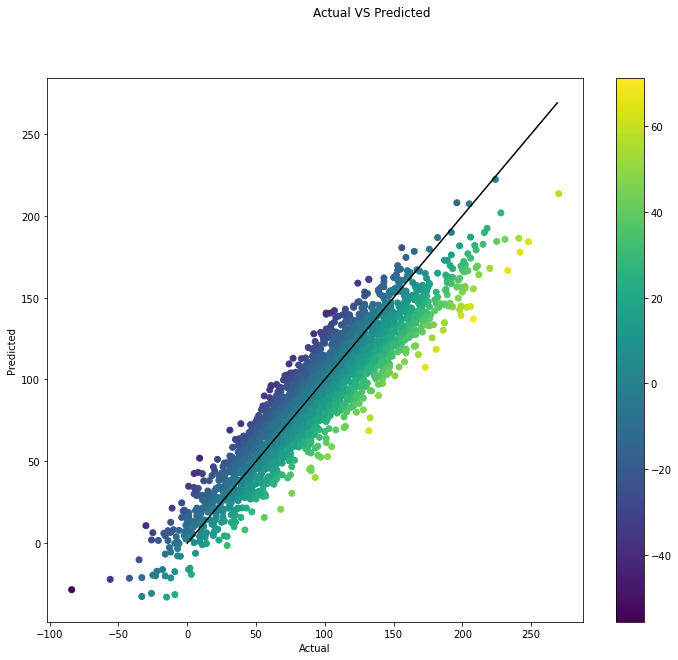

In [12]:
yt = np.array(y_test)
yp = np.transpose(y_pred)

distance = (yt-yp)
colours = distance
fig = plt.figure(figsize = (12,10))
plt.scatter(y_test, y_pred, c = colours, cmap='viridis')
plt.colorbar()

fig.suptitle("Actual VS Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.plot(np.arange(max(y_test)),np.arange(max(y_test)), c = "black")


So it seems our model is kind of able to predict the price to be paid, albeit with quiet a spread as can be seen above


## Run some custom predictions

In [13]:
grades_for_prediction = [[12,15,16,14,11,9,13,16,15,15]]
predicted_money = model.predict(grades_for_prediction)
print(f' for these: {grades_for_prediction[0]} grades, your balance is {round(predicted_money[0][0])}€')


 for these: [12, 15, 16, 14, 11, 9, 13, 16, 15, 15] grades, your balance is 84€
